In [1]:
pip install scikit-learn torch

Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import random

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
def plot_3d(X, y, title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], y)
    plt.title(title)
    plt.show()

In [7]:
D = 2 # размер входа
O = 1 # размер выхода

In [8]:
X, y = make_regression(n_samples=100, n_features=D, n_targets=O, noise=1000, random_state=42)

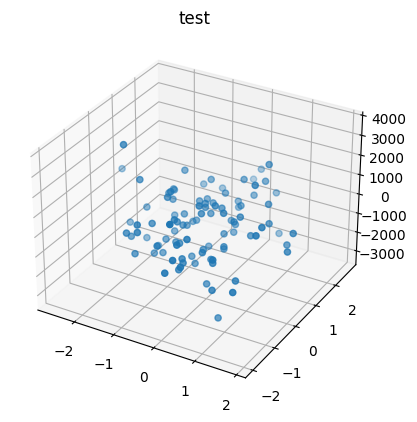

In [9]:
plot_3d(X, y, 'test')

Processing dataset_0:
	{'n_samples': 1000, 'n_features': 2, 'noise': 0.0, 'random_state': 42}



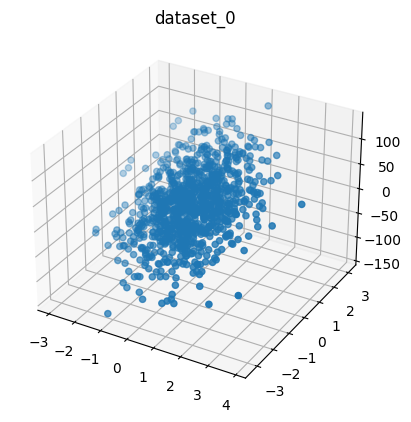

Processing dataset_1:
	{'n_samples': 1000, 'n_features': 2, 'noise': 10.0, 'random_state': 42}



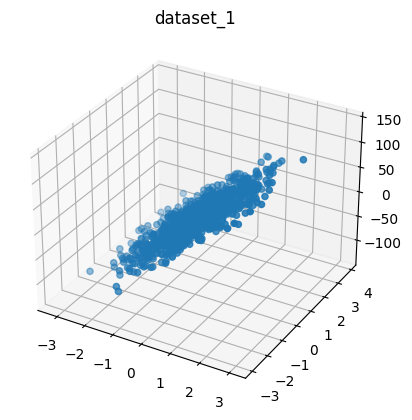

Processing dataset_2:
	{'n_samples': 1000, 'n_features': 2, 'noise': 100.0, 'random_state': 42}



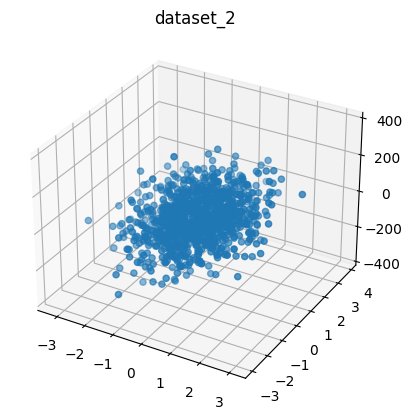

Processing dataset_3:
	{'n_samples': 1000, 'n_features': 2, 'noise': 500.0, 'random_state': 42}



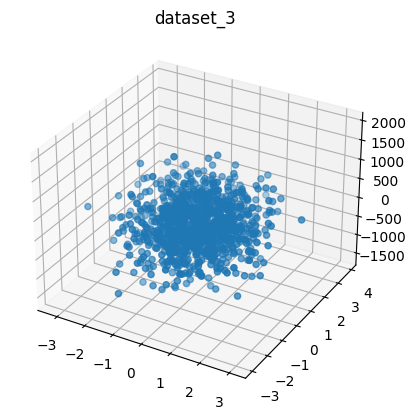

Processing dataset_4:
	{'n_samples': 1000, 'n_features': 2, 'noise': 1000.0, 'random_state': 42}



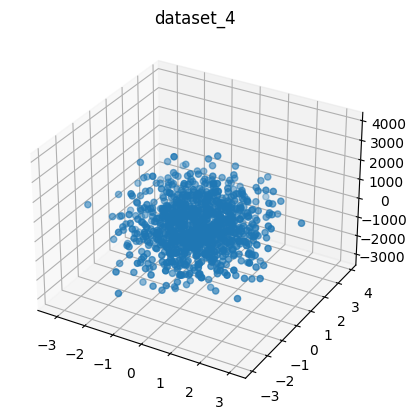

Processing dataset_5:
	{'n_samples': 1000, 'n_features': 2, 'noise': 0.0, 'random_state': 42, 'n_informative': 500}



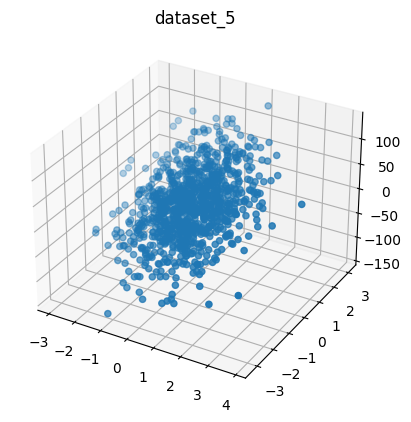

Processing dataset_6:
	{'n_samples': 1000, 'n_features': 2, 'noise': 10.0, 'random_state': 42, 'n_informative': 500}



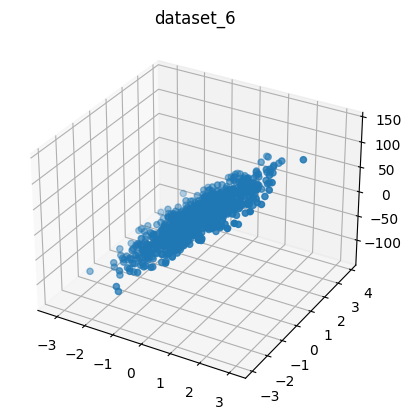

Processing dataset_7:
	{'n_samples': 1000, 'n_features': 2, 'noise': 100.0, 'random_state': 42, 'n_informative': 500}



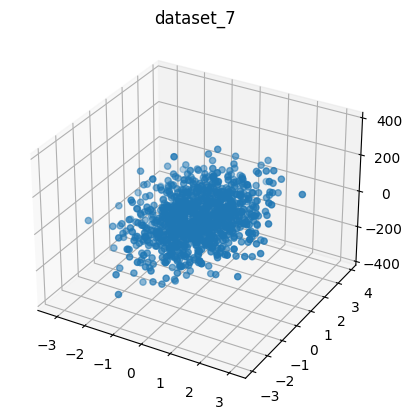

Processing dataset_8:
	{'n_samples': 1000, 'n_features': 2, 'noise': 500.0, 'random_state': 42, 'n_informative': 500}



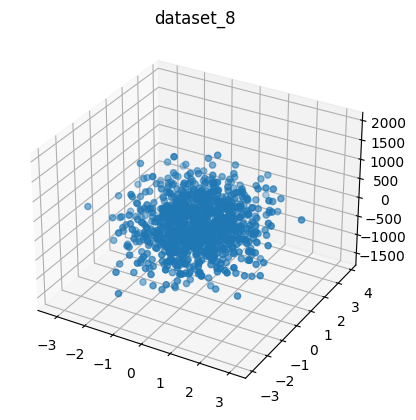

Processing dataset_9:
	{'n_samples': 1000, 'n_features': 2, 'noise': 1000.0, 'random_state': 42, 'n_informative': 500}



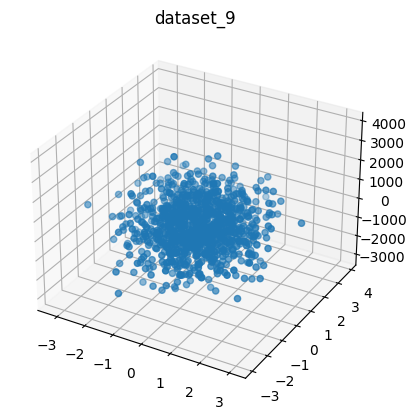

In [101]:
dataset_params = {
    0: {"n_samples": 1000, "n_features": D, "noise": 0.0, "random_state": 42},
    1: {"n_samples": 1000, "n_features": D, "noise": 10.0, "random_state": 42},
    2: {"n_samples": 1000, "n_features": D, "noise": 100.0, "random_state": 42},
    3: {"n_samples": 1000, "n_features": D, "noise": 500.0, "random_state": 42},
    4: {"n_samples": 1000, "n_features": D, "noise": 1000.0, "random_state": 42},
    
    5: {"n_samples": 1000, "n_features": D, "noise": 0.0, "random_state": 42, "n_informative": 500},
    6: {"n_samples": 1000, "n_features": D, "noise": 10.0, "random_state": 42, "n_informative": 500},
    7: {"n_samples": 1000, "n_features": D, "noise": 100.0, "random_state": 42, "n_informative": 500},
    8: {"n_samples": 1000, "n_features": D, "noise": 500.0, "random_state": 42, "n_informative": 500},
    9: {"n_samples": 1000, "n_features": D, "noise": 1000.0, "random_state": 42, "n_informative": 500},
}

for k, v in dataset_params.items():
    print(f"Processing dataset_{k}:\n\t{v}\n")

    train_dataset, test_dataset = generate_dataset(dataset_params[k])
    
    # X, y = make_regression(n_samples=1000, n_features=D, noise=1, random_state=42)
    X, y = make_regression(**dataset_params[k])
    
    plot_3d(X, y, title=f'dataset_{k}')

In [35]:
X = X.astype(np.float32)
y = y.astype(np.float32)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [37]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).reshape(-1, 1)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test).reshape(-1, 1)

In [38]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [39]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Модель 2-3 линейных слоя, ReLU активация
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(D, 16),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(),
            
            nn.Linear(16, 8),
            nn.BatchNorm1d(num_features=8),
            nn.ReLU(),
            
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

Using cuda device


In [40]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 0:
        #    loss, current = loss.item(), (batch + 1) * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [41]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
    
            test_loss += loss_fn(pred, y).item()            
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    # correct /= size
    
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss

In [42]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(1)

In [62]:
def generate_dataset(dataset_params):
    # X, y = make_regression(n_samples=1000, n_features=D, noise=1, random_state=42)
    X, y = make_regression(**dataset_params)
    
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train).reshape(-1, 1)
    X_test = torch.from_numpy(X_test)
    y_test = torch.from_numpy(y_test).reshape(-1, 1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    return train_dataset, test_dataset

In [63]:
def plot_experiment(e):
    for k, v in e.items():
        plt.plot(v, label=k)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Processing dataset_0
Processing batch size: 8


100%|██████████| 200/200 [00:41<00:00,  4.87it/s]


Processing batch size: 16


100%|██████████| 200/200 [00:21<00:00,  9.35it/s]


Processing batch size: 32


100%|██████████| 200/200 [00:11<00:00, 17.16it/s]


Processing batch size: 64


100%|██████████| 200/200 [00:06<00:00, 30.41it/s]


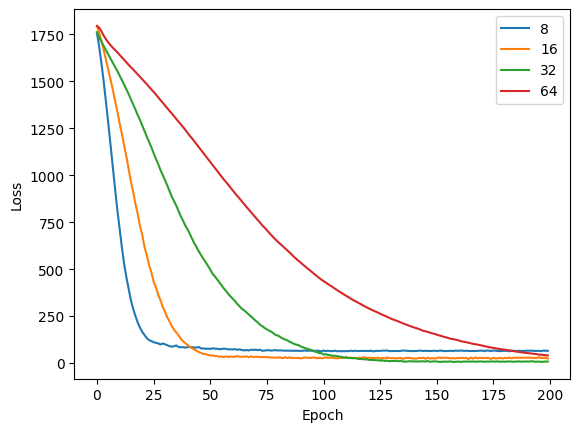

Processing dataset_1
Processing batch size: 8


100%|██████████| 200/200 [00:41<00:00,  4.86it/s]


Processing batch size: 16


100%|██████████| 200/200 [00:21<00:00,  9.30it/s]


Processing batch size: 32


100%|██████████| 200/200 [00:11<00:00, 17.09it/s]


Processing batch size: 64


100%|██████████| 200/200 [00:06<00:00, 29.88it/s]


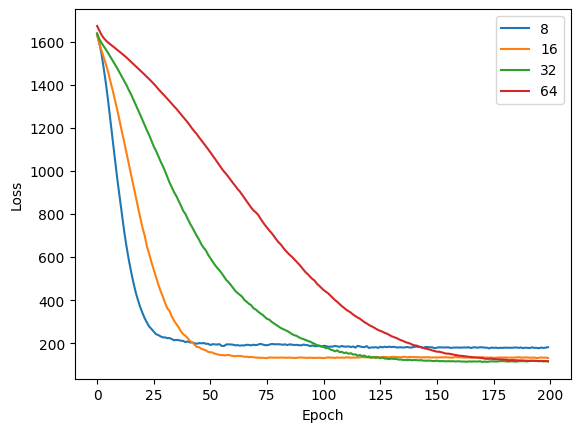

Processing dataset_2
Processing batch size: 8


100%|██████████| 200/200 [00:41<00:00,  4.86it/s]


Processing batch size: 16


100%|██████████| 200/200 [00:21<00:00,  9.29it/s]


Processing batch size: 32


100%|██████████| 200/200 [00:11<00:00, 17.18it/s]


Processing batch size: 64


100%|██████████| 200/200 [00:06<00:00, 30.33it/s]


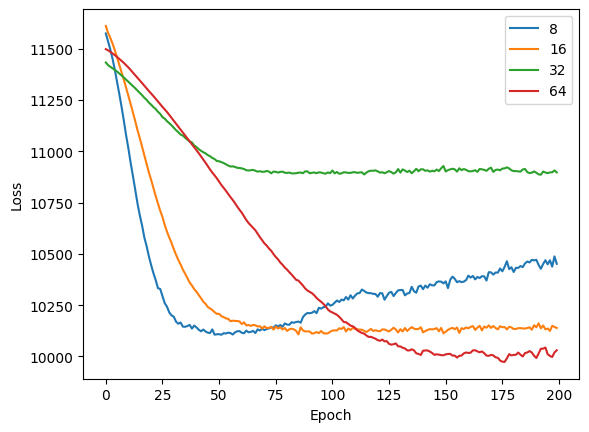

Processing dataset_3
Processing batch size: 8


100%|██████████| 200/200 [00:41<00:00,  4.85it/s]


Processing batch size: 16


100%|██████████| 200/200 [00:21<00:00,  9.29it/s]


Processing batch size: 32


100%|██████████| 200/200 [00:11<00:00, 16.69it/s]


Processing batch size: 64


100%|██████████| 200/200 [00:06<00:00, 30.04it/s]


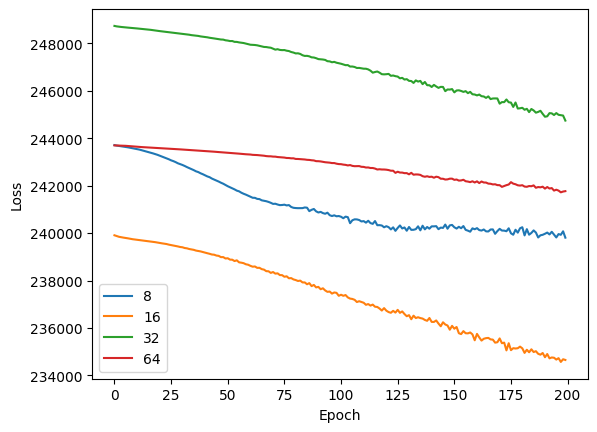

Processing dataset_4
Processing batch size: 8


100%|██████████| 200/200 [00:41<00:00,  4.86it/s]


Processing batch size: 16


100%|██████████| 200/200 [00:21<00:00,  9.11it/s]


Processing batch size: 32


100%|██████████| 200/200 [00:11<00:00, 16.96it/s]


Processing batch size: 64


100%|██████████| 200/200 [00:06<00:00, 30.08it/s]


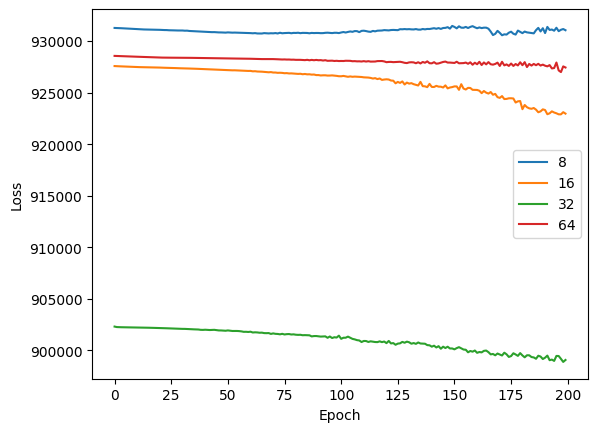

In [69]:
dataset_params = {
    0: {"n_samples": 1000, "n_features": D, "noise": 0.0, "random_state": 42},
    1: {"n_samples": 1000, "n_features": D, "noise": 10.0, "random_state": 42},
    2: {"n_samples": 1000, "n_features": D, "noise": 100.0, "random_state": 42},
    3: {"n_samples": 1000, "n_features": D, "noise": 500.0, "random_state": 42},
    4: {"n_samples": 1000, "n_features": D, "noise": 1000.0, "random_state": 42}
}

for k in dataset_params.keys():
    print(f"Processing dataset_{k}")

    train_dataset, test_dataset = generate_dataset(dataset_params[k])

    batches = [8, 16, 32, 64]
    batch_losses = {b: [] for b in batches}
    
    for b in batches:
        print(f"Processing batch size: {b}")

        epochs = 200

        model = NeuralNetwork().to(device)

        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters())

        train_dataloader = DataLoader(train_dataset, batch_size=b,
                                      worker_init_fn=seed_worker, generator=g)
        test_dataloader = DataLoader(test_dataset, batch_size=b,
                                      worker_init_fn=seed_worker, generator=g)

        for t in tqdm(range(epochs)):
            # print(f"Epoch {t+1}\n-------------------------------")

            train(train_dataloader, model, loss_fn, optimizer)
            avg_loss = test(test_dataloader, model, loss_fn)

            batch_losses[b].append(avg_loss)
            
            
    plot_experiment(batch_losses)

In [66]:
# Модель 2-3 линейных слоя, ReLU активация
class Simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(D, 16),
            nn.ReLU(),
            
            nn.Linear(16, 8),
            nn.ReLU(),
            
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# Модель 2-3 линейных слоя, ReLU активация
class WithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(D, 16),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(),
            
            nn.Linear(16, 8),
            nn.BatchNorm1d(num_features=8),
            nn.ReLU(),
            
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
# Модель 2-3 линейных слоя, ReLU активация
class WithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(D, 16),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
# Модель 2-3 линейных слоя, ReLU активация
class Advanced(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(D, 16),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            
            nn.Linear(16, 8),
            nn.BatchNorm1d(num_features=8),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

Processing dataset_0
Processing model: Simple


100%|██████████| 200/200 [00:17<00:00, 11.58it/s]


Processing model: WithBatchNorm


100%|██████████| 200/200 [00:21<00:00,  9.11it/s]


Processing model: WithDropout


100%|██████████| 200/200 [00:20<00:00,  9.99it/s]


Processing model: Advanced


100%|██████████| 200/200 [00:24<00:00,  8.11it/s]


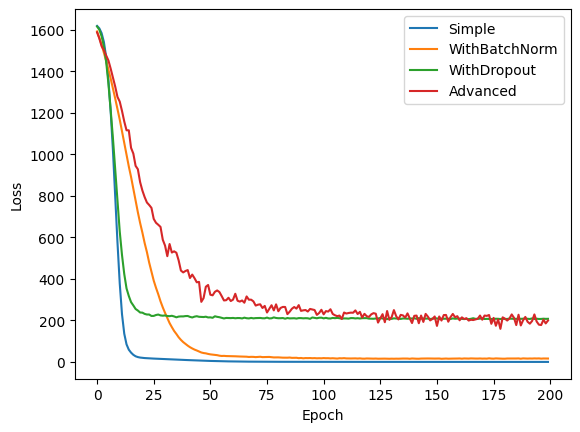

Processing dataset_1
Processing model: Simple


100%|██████████| 200/200 [00:17<00:00, 11.56it/s]


Processing model: WithBatchNorm


100%|██████████| 200/200 [00:21<00:00,  9.23it/s]


Processing model: WithDropout


100%|██████████| 200/200 [00:19<00:00, 10.05it/s]


Processing model: Advanced


100%|██████████| 200/200 [00:24<00:00,  8.19it/s]


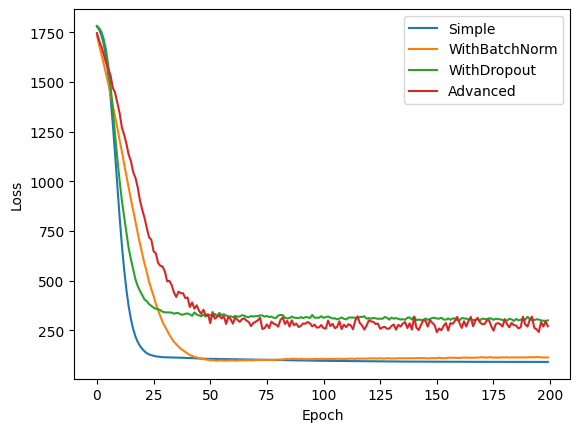

Processing dataset_2
Processing model: Simple


100%|██████████| 200/200 [00:17<00:00, 11.66it/s]


Processing model: WithBatchNorm


100%|██████████| 200/200 [00:21<00:00,  9.12it/s]


Processing model: WithDropout


100%|██████████| 200/200 [00:19<00:00, 10.06it/s]


Processing model: Advanced


100%|██████████| 200/200 [00:24<00:00,  8.06it/s]


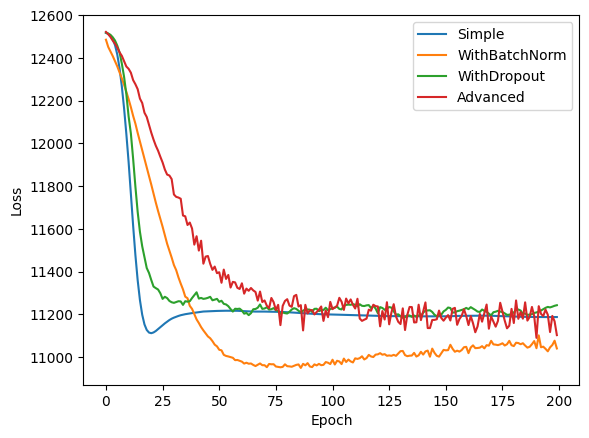

Processing dataset_3
Processing model: Simple


100%|██████████| 200/200 [00:17<00:00, 11.61it/s]


Processing model: WithBatchNorm


100%|██████████| 200/200 [00:21<00:00,  9.11it/s]


Processing model: WithDropout


100%|██████████| 200/200 [00:20<00:00,  9.98it/s]


Processing model: Advanced


100%|██████████| 200/200 [00:24<00:00,  8.14it/s]


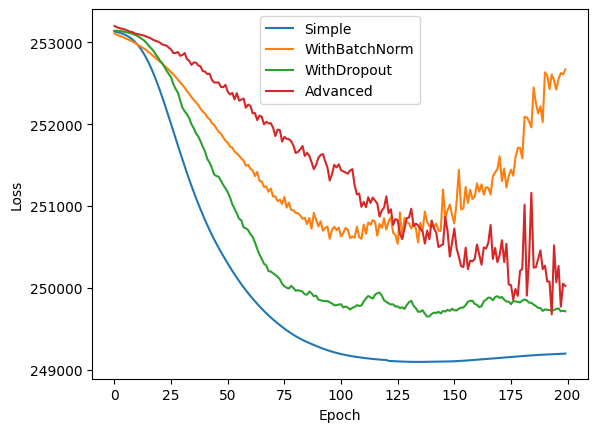

Processing dataset_4
Processing model: Simple


100%|██████████| 200/200 [00:17<00:00, 11.55it/s]


Processing model: WithBatchNorm


100%|██████████| 200/200 [00:21<00:00,  9.23it/s]


Processing model: WithDropout


100%|██████████| 200/200 [00:19<00:00, 10.01it/s]


Processing model: Advanced


100%|██████████| 200/200 [00:24<00:00,  8.16it/s]


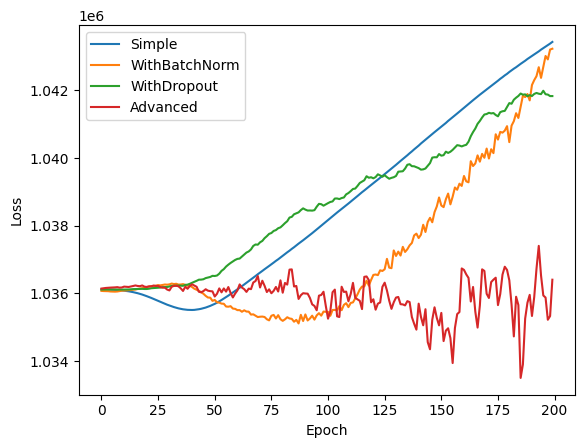

Processing dataset_5
Processing model: Simple


100%|██████████| 200/200 [00:17<00:00, 11.61it/s]


Processing model: WithBatchNorm


100%|██████████| 200/200 [00:21<00:00,  9.12it/s]


Processing model: WithDropout


100%|██████████| 200/200 [00:19<00:00, 10.01it/s]


Processing model: Advanced


100%|██████████| 200/200 [00:24<00:00,  8.15it/s]


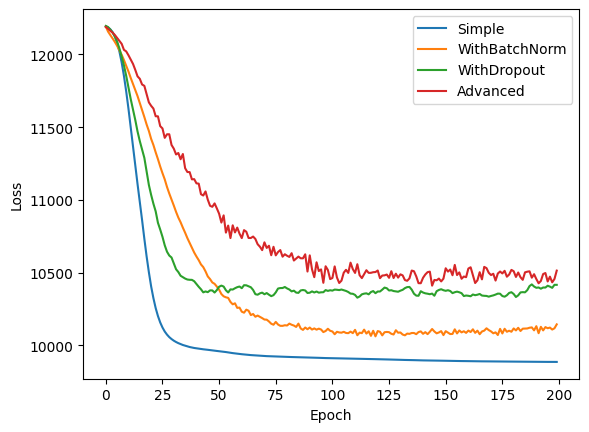

In [71]:
dataset_params = {
    0: {"n_samples": 1000, "n_features": D, "noise": 0.0, "random_state": 42},
    1: {"n_samples": 1000, "n_features": D, "noise": 10.0, "random_state": 42},
    2: {"n_samples": 1000, "n_features": D, "noise": 100.0, "random_state": 42},
    3: {"n_samples": 1000, "n_features": D, "noise": 500.0, "random_state": 42},
    4: {"n_samples": 1000, "n_features": D, "noise": 1000.0, "random_state": 42},
    
    5: {"n_samples": 1000, "n_features": D, "noise": 0.0, "random_state": 42, "n_informative": 500},
    6: {"n_samples": 1000, "n_features": D, "noise": 10.0, "random_state": 42, "n_informative": 500},
    7: {"n_samples": 1000, "n_features": D, "noise": 100.0, "random_state": 42, "n_informative": 500},
    8: {"n_samples": 1000, "n_features": D, "noise": 500.0, "random_state": 42, "n_informative": 500},
    9: {"n_samples": 1000, "n_features": D, "noise": 1000.0, "random_state": 42, "n_informative": 500},
}

for k, v in dataset_params.items():
    print(f"Processing dataset_{k}:\n\t{v}\n")

    train_dataset, test_dataset = generate_dataset(dataset_params[k])
    
    
    best_batch_size = 16

    model_names = ["Simple", "WithBatchNorm", "WithDropout", "Advanced"]
    model_ctors = {
        "Simple": Simple,
        "WithBatchNorm": WithBatchNorm,
        "WithDropout": WithDropout,
        "Advanced": Advanced
    }
    model_losses = {m: [] for m in model_names}

    for m in model_names:
        print(f"Processing model: {m}")

        epochs = 200

        model = model_ctors[m]().to(device)

        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters())

        train_dataloader = DataLoader(train_dataset, batch_size=best_batch_size,
                                      worker_init_fn=seed_worker, generator=g)
        test_dataloader = DataLoader(test_dataset, batch_size=best_batch_size,
                                      worker_init_fn=seed_worker, generator=g)

        for t in tqdm(range(epochs)):
            # print(f"Epoch {t+1}\n-------------------------------")

            train(train_dataloader, model, loss_fn, optimizer)
            avg_loss = test(test_dataloader, model, loss_fn)

            model_losses[m].append(avg_loss)

    plot_experiment(model_losses)